# Importing Required Modules

## General Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm


## Modelling

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelBinarizer
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix, classification_report
from sklearn.model_selection import cross_val_score

## My modules

In [3]:
from my_modules.Predict import classification

# Functions

In [4]:
def text_classification(x, y, vect_model, pred_model, test_size=0.2, random_state=0, cv=10, pipeline_flag=False):

    # Train/Test Split
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=test_size, random_state=random_state, stratify=y)

    if not pipeline_flag:

        # Vectorization
        vect_model.fit(x_train)
        x_vect_train = vect_model.transform(x_train)
        x_vect_test = vect_model.transform(x_test)

        # Prediction
        output = classification(x_vect_train, y_train, x_vect_test, y_test, pred_model, cv=cv)

    if pipeline_flag:

        # Create pipeline - Vectorization-Prediction
        pipeline = make_pipeline(vect_model, pred_model)

        # Run pipeline
        output = classification(x_train, y_train, x_test, y_test, pipeline, cv=cv)


    return output

    

# Loading the data

In [5]:
path = "Data/financial/fin_red_data_processed.csv"
df = pd.read_csv(path)

# From Words to Numbers

In [6]:
y = df["sentiment"]
x = df["lemmas"]

lb = LabelBinarizer()
y = np.ravel(lb.fit_transform(y))


In [7]:
df

,text,lemmas,ngrams,named_ents,sentiment
0,European traffic grew nearly 30 % .,"['european', 'traffic', 'grow', 'nearly']",['european_traffic'],[],positive
1,Singapore in May 2011 1 July 2010 Finnish air ...,"['finnish', 'air', 'carrier', 'say', 'today', ...","['finnish_air', 'finnish_air_carrier', 'say_to...","['Singapore/GPE', 'Singapore/GPE']",positive
2,"Ragutis , controlled by the Finnish brewery Ol...","['control', 'finnish', 'brewery', 'achieve', '...",['finnish_brewery'],[],positive
3,Outotec 's net profit for the second quarter o...,"['net', 'profit', 'second', 'quarter', 'jump',...","['net_profit', 'second_quarter']",[],positive
4,"In addition , the production at the Varpaisj+_...","['addition', 'production', 'factory', 'stop', ...",[],[],negative
...,...,...,...,...,...
1193,Operating profit excluding non-recurring items...,"['operate', 'profit', 'exclude', 'non', 'recur...","['operate_profit', 'recurring_item', 'correspo...",[],negative
1194,Nordic banks have already had to write off siz...,"['nordic', 'bank', 'write', 'sizable', 'loan',...","['nordic_bank', 'sizable_loan', 'combine_loss'...","['Latvia/GPE', 'Latvia/GPE']",negative
1195,"Operating loss totalled EUR 4.0 mn , compared ...","['operating', 'loss', 'total', 'compare', 'pro...",['second_quarter'],[],negative
1196,Both operating profit and turnover for the six...,"['operate', 'profit', 'turnover', 'month', 'pe...","['operate_profit', 'corresponding_period']",[],positive


In [8]:
print(y)

[1 1 1 ... 0 1 0]


## Train/test Split

In [9]:
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=0, stratify=y)

In [10]:
x_train

861     ['net', 'sale', 'fall', 'previous', 'accountin...
776     ['commission', 'income', 'increase', 'lending'...
491     ['compare', 'index', 'rise', 'point', 'day', '...
544     ['company', 'aim', 'annual', 'saving', 'm', 'm...
836     ['finnish', 'financial', 'software', 'develope...
                              ...                        
1128    ['finnish', 'business', 'information', 'system...
71      ['operate', 'profit', 'exclude', 'non', 'recur...
1015    ['company', 'aim', 'annual', 'saving', 'm', 'm...
131     ['cost', 'new', 'ropax', 'vessel', 'low', 'pre...
868     ['separate', 'business', 'able', 'fast', 'expa...
Name: lemmas, Length: 958, dtype: object

In [11]:
x_test

482     ['talk', 'aim', 'restructure', 'operation', 'c...
1112    ['happy', 'work', 'encourage', 'boater', 'angl...
77      ['challenge', 'oil', 'production', 'scale', 'f...
1137    ['finnish', 'swedish', 'understand', 'decision...
670     ['say', 'second', 'quarter', 'result', 'fall',...
                              ...                        
532                         ['operate', 'margin', 'come']
144                          ['earning', 'share', 'loss']
451     ['net', 'income', 'life', 'insurance', 'rise',...
220     ['operating', 'loss', 'total', '25mn', 'compar...
280     ['rise', 'cost', 'force', 'packaging', 'produc...
Name: lemmas, Length: 240, dtype: object

In [12]:
pd.DataFrame(y_train)[0].value_counts()

0    479
1    479
Name: 0, dtype: int64

In [13]:
pd.DataFrame(y_test)[0].value_counts()

1    120
0    120
Name: 0, dtype: int64

## Vectorization - Bag of Words

In [14]:
cv = CountVectorizer()

In [15]:
cv.fit(x_train)

x_bow_train = cv.transform(x_train)
x_bow_test = cv.transform(x_test)

print(f'x_bow_train: {x_bow_train.shape}')
print(f'x_bow_test: {x_bow_test.shape}')

x_bow_train: (958, 1802)
x_bow_test: (240, 1802)


In [16]:
x_bow_train_df = pd.DataFrame(x_bow_test.toarray(), columns=cv.get_feature_names())

C:\Users\user\miniconda3\envs\DA_ENV\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


### Top 100 more frequent lemmas in the IMDb train corpus

In [17]:
list_tuples = []

for column in x_bow_train_df.columns:

    list_tuples.append((column, x_bow_train_df[column].sum()))

In [18]:
list_tuples.sort(key=lambda tup:tup[1], reverse=True)
print(list_tuples[0:100])

[('profit', 48), ('net', 39), ('say', 39), ('year', 39), ('company', 38), ('period', 38), ('sale', 37), ('finnish', 30), ('mln', 29), ('quarter', 28), ('total', 24), ('share', 23), ('compare', 21), ('corresponding', 18), ('euro', 18), ('loss', 18), ('operate', 18), ('decrease', 16), ('increase', 16), ('today', 15), ('fall', 12), ('market', 12), ('operation', 12), ('rise', 12), ('operating', 11), ('result', 11), ('second', 11), ('month', 10), ('eur', 9), ('half', 9), ('lay', 9), ('maker', 9), ('product', 9), ('business', 8), ('contract', 8), ('cost', 8), ('drop', 8), ('employee', 8), ('estimate', 8), ('percent', 8), ('price', 8), ('solution', 8), ('cash', 7), ('continue', 7), ('early', 7), ('earning', 7), ('new', 7), ('order', 7), ('pct', 7), ('reduce', 7), ('service', 7), ('sign', 7), ('accord', 6), ('agreement', 6), ('aim', 6), ('amount', 6), ('demand', 6), ('flow', 6), ('grow', 6), ('report', 6), ('see', 6), ('unit', 6), ('able', 5), ('announce', 5), ('base', 5), ('construction', 5),

## Vectorization - TF - IDF

In [19]:
tfidf = TfidfVectorizer()

In [20]:
tfidf.fit(x_train)

x_tfidf_train = tfidf.transform(x_train)
x_tfidf_test = tfidf.transform(x_test)

print(f'x_tfidf_train: {x_bow_train.shape}')
print(f'x_tfidf_test: {x_bow_test.shape}')

x_tfidf_train: (958, 1802)
x_tfidf_test: (240, 1802)


# A flexible function for text classification

## Random Forest

In [64]:
rf=RandomForestClassifier(max_depth=20, n_estimators=100, random_state=0)

### Bag of Words - raw text

-----------------
The model score using K-fold cross validation (k=15) is 0.788 with a standard deviation of 0.056
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.788161,-
val_std (k=15),0.056004,-
accuracy,0.950939,0.8
precision,0.920233,0.764706
recall,0.987474,0.866667


-----------------
Confusion matrix for the train set
-----------------


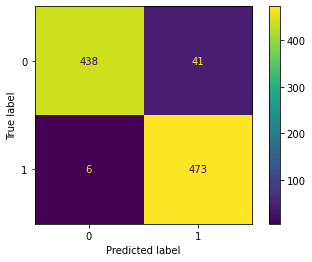

Confusion matrix for the test set
-----------------


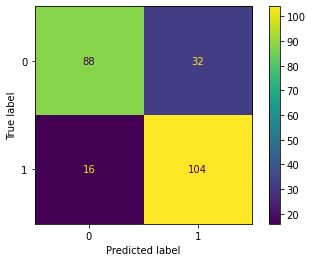

In [67]:
output_rf_bow_raw = text_classification(df["text"], y, CountVectorizer(), rf, cv=15, test_size=0.2, random_state=0, pipeline_flag=True)

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=15) is 0.82 with a standard deviation of 0.059
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.820403,-
val_std (k=15),0.058621,-
accuracy,0.917537,0.8125
precision,0.889105,0.78626
recall,0.954071,0.858333


-----------------
Confusion matrix for the train set
-----------------


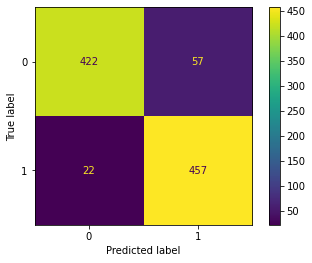

Confusion matrix for the test set
-----------------


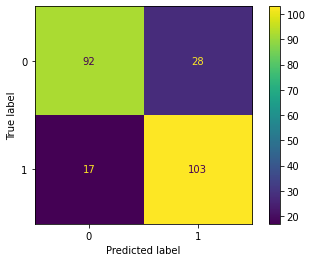

In [71]:
output_rf_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), rf, cv=15, test_size=0.2, random_state=20, pipeline_flag=True)

### Bag of Words - ngrams

-----------------
The model score using K-fold cross validation (k=10) is 0.514 with a standard deviation of 0.028
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.513553,-
val_std (k=10),0.028459,-
accuracy,0.557411,0.5625
precision,0.536424,0.539683
recall,0.845511,0.85


-----------------
Confusion matrix for the train set
-----------------


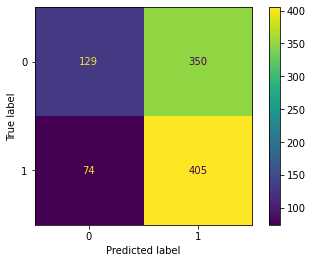

Confusion matrix for the test set
-----------------


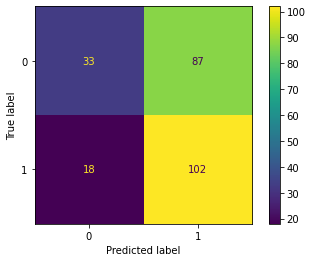

In [24]:
output_rf_bow_ngrams = text_classification(df["ngrams"], y, CountVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_IDF - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.774 with a standard deviation of 0.034
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.773520,-
val_std (k=10),0.034093,-
accuracy,0.850731,0.804167
precision,0.832016,0.796748
recall,0.878914,0.816667


-----------------
Confusion matrix for the train set
-----------------


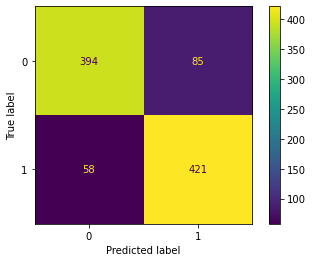

Confusion matrix for the test set
-----------------


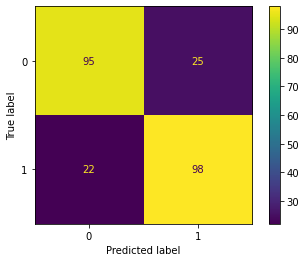

In [25]:
output_rf_tfidf_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), rf, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

## SVM

In [26]:
svm = LinearSVC(random_state=0, tol=1e-2, max_iter=5000)

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.805 with a standard deviation of 0.041
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.804836,-
val_std (k=10),0.041271,-
accuracy,0.995825,0.816667
precision,1.000000,0.801587
recall,0.991649,0.841667


-----------------
Confusion matrix for the train set
-----------------


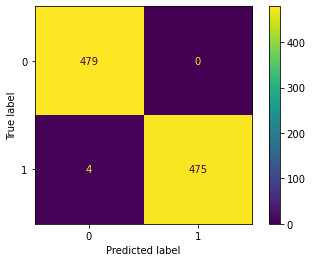

Confusion matrix for the test set
-----------------


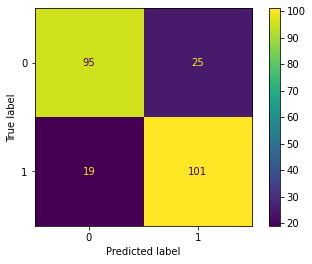

In [27]:
output_svm_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### Bag of Words - ngrams

-----------------
The model score using K-fold cross validation (k=10) is 0.542 with a standard deviation of 0.033
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.541743,-
val_std (k=10),0.032521,-
accuracy,0.839248,0.504167
precision,0.973761,0.517241
recall,0.697286,0.125


-----------------
Confusion matrix for the train set
-----------------


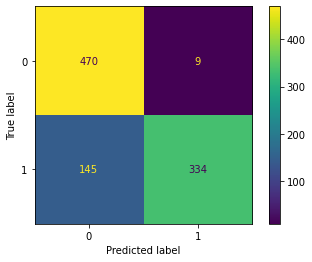

Confusion matrix for the test set
-----------------


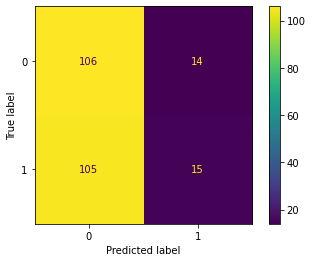

In [28]:
output_svm_bow_ngrams = text_classification(df["ngrams"], y, CountVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.83 with a standard deviation of 0.04
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.829912,-
val_std (k=10),0.039912,-
accuracy,0.986430,0.833333
precision,0.995745,0.807692
recall,0.977035,0.875


-----------------
Confusion matrix for the train set
-----------------


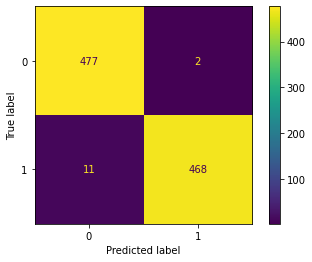

Confusion matrix for the test set
-----------------


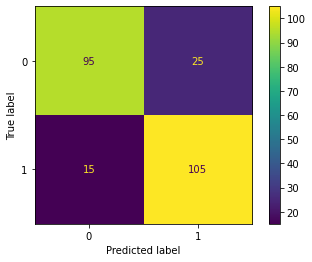

In [29]:
output_svm_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), svm, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

## Naive Bayes

In [30]:
nb = MultinomialNB()

### Bag of Words - Lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.801 with a standard deviation of 0.027
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.800614,-
val_std (k=10),0.026620,-
accuracy,0.920668,0.808333
precision,0.987893,0.855769
recall,0.851775,0.741667


-----------------
Confusion matrix for the train set
-----------------


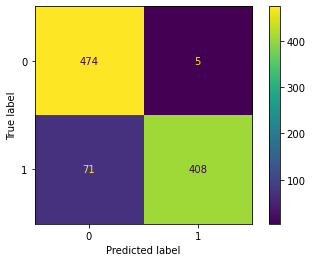

Confusion matrix for the test set
-----------------


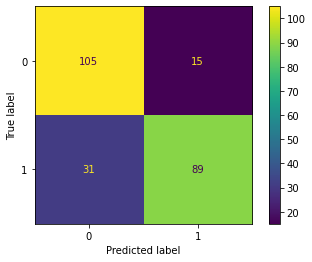

In [31]:
output_nb_bow_lemmas = text_classification(df["lemmas"], y, CountVectorizer(), nb, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

### TF_ITF - lemmas

-----------------
The model score using K-fold cross validation (k=10) is 0.81 with a standard deviation of 0.031
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=10),0.810011,-
val_std (k=10),0.031248,-
accuracy,0.932150,0.829167
precision,0.985915,0.869159
recall,0.876827,0.775


-----------------
Confusion matrix for the train set
-----------------


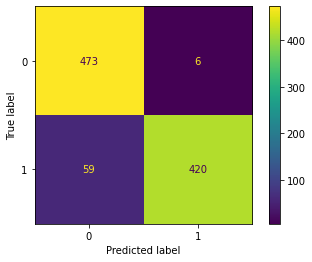

Confusion matrix for the test set
-----------------


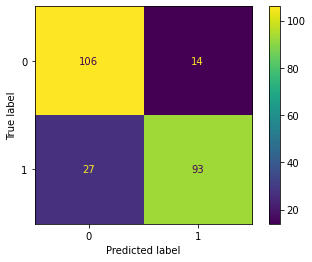

In [32]:
output_nb_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), nb, cv=10, test_size=0.2, random_state=0, pipeline_flag=True)

# Final Model - Naive Bayes with TF_IDF and lemmas

-----------------
The model score using K-fold cross validation (k=15) is 0.814 with a standard deviation of 0.055
-----------------
The performance metrics of the model


,train,test
error_metric,,
val_mean_score (k=15),0.814137,-
val_std (k=15),0.054667,-
accuracy,0.936326,0.833333
precision,0.979358,0.87037
recall,0.891441,0.783333


-----------------
Confusion matrix for the train set
-----------------


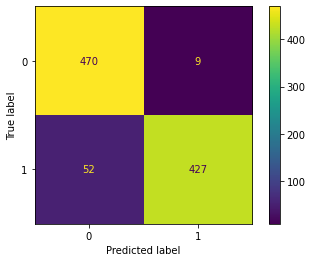

Confusion matrix for the test set
-----------------


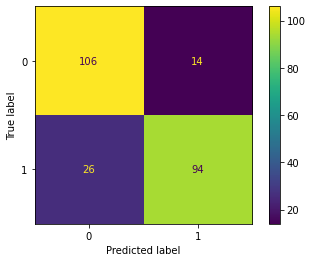

In [73]:
nb = MultinomialNB()
output_nb_tfif_lemmas = text_classification(df["lemmas"], y, TfidfVectorizer(), nb, cv=15, test_size=0.2, random_state=20, pipeline_flag=True)

In [34]:
output_nb_tfif_lemmas.keys()

dict_keys(['model', 'val_scores', 'prediction_results', 'performance_metrics'])

In [35]:
output_nb_tfif_lemmas["prediction_results"]

,train,test
y,"[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...","[1, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 0, 1, ..."
y_pred,"[0, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, ...","[0, 1, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 1, 0, 1, ..."


In [36]:
y_pred_test = output_nb_tfif_lemmas["prediction_results"].loc["y_pred", "test"]

In [37]:
print(classification_report(y_test, y_pred_test))

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       120
           1       0.87      0.78      0.82       120

    accuracy                           0.83       240
   macro avg       0.83      0.83      0.83       240
weighted avg       0.83      0.83      0.83       240

